<a href="https://colab.research.google.com/github/leandra-mara/MVP--Machine-Learning-e-Analytics/blob/main/2025_09_28_MVP_ML_Leandra_Mara_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MVP — Machine Learning & Analytics (Classificação de Gastos)**  
**Aluno(a):** Leandra Mara da Silva  
**Data:** 27/09/2025  
**Reprodutibilidade:** *seeds fixas + pipelines sem vazamento*

> **Contexto:** Este notebook é a continuação da sprint anterior (Análise de Dados). Agora, o foco é aplicar **Machine Learning** para classificar despesas em **fixas obrigatórias**, **variáveis essenciais** e **variáveis discricionárias**.  
> Trata-se do meu primeiro trabalho estudando e abordando conceitos de Machine Learning. Em cada etapa, tento disponibilizar justificativas das escolhas, comentário dentro do código e faço uso de pipelines buscando evitar vazamento de dados.


## 1. Introdução (Contexto resumido)

- **Persona:** Alessandra deseja reduzir despesas ao longo de 2025. O aplicativo do banco **não** categoriza gastos.  
- **Problema:** O dataset original com  transações bancárias (também usado na sprint anterior) vem **sem rótulos** de categoria (fixa, essencial, discricionária) e queremos avançar nos estudos de aprendizado supersionado.  
- **Solução adotada:** Criamos **rótulos por heurísticas** com base no conhecimento real da correntista (evita rotular linha a linha manualmente).  
- **Objetivo desta sprint:** construir um **classificador supervisionado** que ajude a organizar o orçamento por categorias e apoiar metas de redução.

**O que foi feito na sprint anterior (Análise de Dados):**  
- Exploramos padrão de gastos por mês, por tipo de operação, por quinzena, PIX (PF vs PJ), dias da semana etc.  
- Aqui **não repetiremos** todo o EDA. Apenas traremos um único gráfico simples **como contexto** e que confirma o esforço de Alessandra Dias na redução de despesas. A partir daí, partiremos para o **EDA voltado à ML** (distribuição de rótulos, balanceamento, etc.), o que não foi abordado no dado não rotulado da sprint anterior.

**Pontos importantes sobre heurísticas e pipeline:**  
- O **pipeline do scikit-learn** protege contra **vazamento técnico** (treino vs. teste) nas transformações.  
- As **heurísticas** criam os **rótulos** antes do pipeline. Elas **não causam vazamento técnico**, mas podem introduzir **viés** (o modelo aprende a reproduzir regras).  
- Vamos **registrar essa limitação** e indicar **trabalhos futuros** para medir esse efeito (ex.: usar um dataset já rotulado externamente).

**O que entregaremos:**  
- Pipelines sem vazamento, **modelos clássicos** (KNN, CART, GaussianNB, SVM) + **LogReg, RandomForest, MultinomialNB**,  
- **Feature selection** (SelectKBest no texto),  
- Métrica **F1_macro** (por haver possível desbalanceamento de classes),  
- **Análise de erros**, **fechamento** e **checklist do escopo solicitado**.


## 2. Setup e reprodutibilidade

In [102]:
# === 2. Setup e reprodutibilidade ===
# !pip install scikit-learn pandas numpy matplotlib --quiet

import warnings, sys, platform
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2

# Modelos
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC, LinearSVC

# Reprodutibilidade (seed)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Versões:")
print("Python:", sys.version.split()[0])
print("NumPy:", np.__version__)
print("pandas:", pd.__version__)
print("SO:", platform.system(), platform.release())

Versões:
Python: 3.12.11
NumPy: 2.0.2
pandas: 2.2.2
SO: Linux 6.6.97+


## 3. Carregamento do dataset

- **Fluxo adotado (A):** carregar o dataset **cru** (sem rótulos), aplicar **regras/heurísticas** para criar as classes e seguir para ML.  
- **Trabalho futuro (B):** carregar um dataset **já rotulado externamente** (sem heurística “interna”) e comparar se há diferença (efeito de viés).


In [103]:
# URL pública
URL_DADOS = "https://raw.githubusercontent.com/leandra-mara/MVP--Machine-Learning-e-Analytics/refs/heads/main/NU_01JAN2025_30JUN2025_aberto_transacoes_2025.csv"

# Carregar CSV
df_raw = pd.read_csv(URL_DADOS)
print("Dimensões (raw):", df_raw.shape)
df_raw.head()

Dimensões (raw): (395, 4)


,Data,Valor,Identificador,Descrição
0,01/01/2025,-186.58,67759f90-ade1-43a5-87b7-60d6294701cc,Transferência enviada pelo Pix - AMAZON.COM.BR...
1,02/01/2025,-466.50,67768da2-080a-46d7-a53a-0e00edb4b1dc,Compra no débito - Supermercados Mundia
2,03/01/2025,-4.99,6777b829-26b5-4d20-bedc-0a781b7b3a22,Compra no débito - Padaria e Confeitaria
3,03/01/2025,-39.60,6777bd03-ad0f-491e-b2b4-f9902450f3fe,Compra no débito - Sacolao Volante
4,03/01/2025,-38.00,6777f778-59f2-4f77-a2c0-ff348d0b4405,Compra no débito - Sacolao Volante


## 4. Pré-processamento (resumo + funções)

**Resumo do que faremos:**  
1. Normalizar nomes de colunas.  
2. Extrair informações temporais úteis (dia do mês, mês, dia da semana, quinzena).  
3. Separar a coluna `descrição` em partes (tipo de operação, beneficiário, etc.).  
4. Classificar destino PIX em PF/PJ (quando aplicável).  
5. Classificar tipo de saída (pagamento de despesa vs. investimento vs. migração entre contas).  
6. Manter apenas os **gastos reais** (`pgto_despesa`) e trabalhar com **valor absoluto**.


In [106]:
import unicodedata
import re

def normalizar_nomes_colunas(df):
    """
    Deixa os nomes das colunas padronizados (minúsculas, sem acentos, com _).
    Essa padronização facilita todo o restante do processamento.
    """
    df = df.copy()
    def limpar(col):
        col = unicodedata.normalize("NFKD", col).encode("ASCII","ignore").decode("utf-8")
        return col.lower().strip().replace(" ", "_").replace("ç", "c")
    df.columns = [limpar(c) for c in df.columns]
    return df

def filtrar_saidas(df: pd.DataFrame, col_valor: str = "valor") -> pd.DataFrame:
    # Mantém apenas valores negativos (saídas) e torna valor positivo (magnitude do gasto)
    out = df[df[col_valor] < 0].copy()
    out[col_valor] = out[col_valor].abs()
    return out

def classificar_quinzena(dia):
    """1ª metade do mês = 1ª_quinzena; 2ª metade = 2ª_quinzena."""
    return "1ª_quinzena" if dia <= 15 else "2ª_quinzena"

def extrair_info_temporal(df, col_data="data"):
    """Cria colunas: dia_do_mes, mes (número), ano, dow (0=Seg..6=Dom), quinzena."""
    df = df.copy()
    df[col_data] = pd.to_datetime(df[col_data], dayfirst=True, errors="coerce")
    df["dia_do_mes"] = df[col_data].dt.day
    df["mes"]        = df[col_data].dt.month
    df["ano"]        = df[col_data].dt.year
    df["dow"]        = df[col_data].dt.weekday
    df["quinzena"]   = df["dia_do_mes"].apply(classificar_quinzena)
    return df


def separar_descricao(df, col="descricao"):
    """
    Divide a coluna 'descricao' em 4 partes, quando possível, usando ' - ' como separador:
    1) tipo_operacao  2) beneficiario  3) pix_destino  4) outras_informacoes
    """
    df = df.copy()
    df[col] = df[col].astype(str)
    partes = df[col].str.split(" - ", n=3, expand=True)
    df["tipo_operacao"]      = partes[0]
    df["beneficiario"]       = partes[1]
    df["pix_destino"]        = partes[2]
    df["outras_informacoes"] = partes[3]
    return df

def classificar_pix_pf_pj(df):
    """Se tem '/' no destino (CNPJ) = 'pj'; se tem '•' (CPF mascarado) = 'pf'; senão 'nao_se_aplica'."""
    df = df.copy()
    def tipo(x):
        if isinstance(x, str):
            if "/" in x:   # CNPJ
                return "pj"
            if "•" in x:   # CPF mascarado
                return "pf"
        return "nao_se_aplica"
    df["tipo_pix"] = df["pix_destino"].apply(tipo)
    return df

def classificar_saida_aux(df: pd.DataFrame, coluna_descricao: str = "descricao") -> pd.DataFrame:
  df = df.copy()
  condicoes = [
      df[coluna_descricao].str.contains("Alessandra Dias", case=False, na=False),
      df[coluna_descricao].str.contains(r"\b(?:LCA|RDB|LCI|CDB)\b", case=False, na=False)
  ]
  valores = ["migracao_entre_contas", "investimento"]
  valor_default = "pgto_despesa"
  pos_valor = df.columns.get_loc(coluna_descricao) +1
  # Remover coluna se já existir
  for col in ["classificacao"]:
      if col in df.columns:
          df.drop(columns=col, inplace=True)
  # Insere nova coluna
  df.insert(pos_valor, "classificacao", np.select(condicoes, valores, default=valor_default))
  return df

def tratar_nulos_semanticos(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for col in ["beneficiario","pix_destino", "outras_informacoes"]:
        if col in df.columns:
            df[col] = df[col].fillna("nao_se_aplica")
    return df

# Aplicando as funções
# Pipeline de pré-ETL (antes da modelagem)
df = normalizar_nomes_colunas(df_raw)
df = filtrar_saidas(df, "valor")  # apenas saídas
df = extrair_info_temporal(df, "data")

df = classificar_saida_aux(df, "descricao") #para depois pegarmos apenas despesas reais
df = separar_descricao(df, "descricao")
df = classificar_pix_pf_pj(df)

df = tratar_nulos_semanticos(df)

print("Após pré-processamento (todas as saídas) | shape:", df.shape)
df.head()



Após pré-processamento (todas as saídas) | shape: (377, 15)


,data,valor,identificador,descricao,classificacao,dia_do_mes,mes,ano,dow,quinzena,tipo_operacao,beneficiario,pix_destino,outras_informacoes,tipo_pix
0,2025-01-01,186.58,67759f90-ade1-43a5-87b7-60d6294701cc,Transferência enviada pelo Pix - AMAZON.COM.BR...,pgto_despesa,1,1,2025,2,1ª_quinzena,Transferência enviada pelo Pix,AMAZON.COM.BR,26.446.040/0002-04,EBANX IP LTDA. (0484) Agência: 2 Conta: 200082...,pj
1,2025-01-02,466.50,67768da2-080a-46d7-a53a-0e00edb4b1dc,Compra no débito - Supermercados Mundia,pgto_despesa,2,1,2025,3,1ª_quinzena,Compra no débito,Supermercados Mundia,nao_se_aplica,nao_se_aplica,nao_se_aplica
2,2025-01-03,4.99,6777b829-26b5-4d20-bedc-0a781b7b3a22,Compra no débito - Padaria e Confeitaria,pgto_despesa,3,1,2025,4,1ª_quinzena,Compra no débito,Padaria e Confeitaria,nao_se_aplica,nao_se_aplica,nao_se_aplica
3,2025-01-03,39.60,6777bd03-ad0f-491e-b2b4-f9902450f3fe,Compra no débito - Sacolao Volante,pgto_despesa,3,1,2025,4,1ª_quinzena,Compra no débito,Sacolao Volante,nao_se_aplica,nao_se_aplica,nao_se_aplica
4,2025-01-03,38.00,6777f778-59f2-4f77-a2c0-ff348d0b4405,Compra no débito - Sacolao Volante,pgto_despesa,3,1,2025,4,1ª_quinzena,Compra no débito,Sacolao Volante,nao_se_aplica,nao_se_aplica,nao_se_aplica


In [107]:
# Filtramos apenas os gastos reais (pagamentos de despesas)
gastos = df[df["classificacao"] == "pgto_despesa"].copy()

print("Após pré-processamento (apenas gastos reais) | shape:", gastos.shape)
gastos.head()

Após pré-processamento (apenas gastos reais) | shape: (369, 15)


,data,valor,identificador,descricao,classificacao,dia_do_mes,mes,ano,dow,quinzena,tipo_operacao,beneficiario,pix_destino,outras_informacoes,tipo_pix
0,2025-01-01,186.58,67759f90-ade1-43a5-87b7-60d6294701cc,Transferência enviada pelo Pix - AMAZON.COM.BR...,pgto_despesa,1,1,2025,2,1ª_quinzena,Transferência enviada pelo Pix,AMAZON.COM.BR,26.446.040/0002-04,EBANX IP LTDA. (0484) Agência: 2 Conta: 200082...,pj
1,2025-01-02,466.50,67768da2-080a-46d7-a53a-0e00edb4b1dc,Compra no débito - Supermercados Mundia,pgto_despesa,2,1,2025,3,1ª_quinzena,Compra no débito,Supermercados Mundia,nao_se_aplica,nao_se_aplica,nao_se_aplica
2,2025-01-03,4.99,6777b829-26b5-4d20-bedc-0a781b7b3a22,Compra no débito - Padaria e Confeitaria,pgto_despesa,3,1,2025,4,1ª_quinzena,Compra no débito,Padaria e Confeitaria,nao_se_aplica,nao_se_aplica,nao_se_aplica
3,2025-01-03,39.60,6777bd03-ad0f-491e-b2b4-f9902450f3fe,Compra no débito - Sacolao Volante,pgto_despesa,3,1,2025,4,1ª_quinzena,Compra no débito,Sacolao Volante,nao_se_aplica,nao_se_aplica,nao_se_aplica
4,2025-01-03,38.00,6777f778-59f2-4f77-a2c0-ff348d0b4405,Compra no débito - Sacolao Volante,pgto_despesa,3,1,2025,4,1ª_quinzena,Compra no débito,Sacolao Volante,nao_se_aplica,nao_se_aplica,nao_se_aplica


In [108]:
def filtrar_linhas_por_valor(df: pd.DataFrame, coluna: str, valor: str) -> pd.DataFrame:
    """
    Retorna as linhas do DataFrame onde o valor da coluna corresponde ao valor informado,
    ignorando espaços extras e diferenças de caixa (maiúsculas/minúsculas).
    """
    filtro = df[coluna].astype(str).str.strip().str.lower() == valor.strip().lower()
    return df[filtro]

In [109]:
# verificando as saídas referentes a investimentos
linhas_investimento = filtrar_linhas_por_valor(df, "classificacao", "investimento")
print(linhas_investimento["classificacao"].value_counts())
linhas_investimento.head()

classificacao
investimento    4
Name: count, dtype: int64


,data,valor,identificador,descricao,classificacao,dia_do_mes,mes,ano,dow,quinzena,tipo_operacao,beneficiario,pix_destino,outras_informacoes,tipo_pix
40,2025-01-10,20000.00,67811ee0-06b3-41fc-8344-452d19707445,Compra de CDB - Nubank,investimento,10,1,2025,4,1ª_quinzena,Compra de CDB,Nubank,nao_se_aplica,nao_se_aplica,nao_se_aplica
60,2025-01-22,50000.00,679107ae-d2db-4172-a0cd-20f14671e9e9,Aplicação LCA - Banco Original,investimento,22,1,2025,2,2ª_quinzena,Aplicação LCA,Banco Original,nao_se_aplica,nao_se_aplica,nao_se_aplica
285,2025-05-13,2022.64,68232387-89f4-4e10-9f73-e085863433d5,Aplicação RDB,investimento,13,5,2025,1,1ª_quinzena,Aplicação RDB,nao_se_aplica,nao_se_aplica,nao_se_aplica,nao_se_aplica
286,2025-05-13,2977.36,68232b4f-344e-4995-9afd-95f5c85a48f3,Aplicação RDB,investimento,13,5,2025,1,1ª_quinzena,Aplicação RDB,nao_se_aplica,nao_se_aplica,nao_se_aplica,nao_se_aplica


In [110]:
# verificando as saídas referentes a migração entre contas da titular
linhas_migracao_entre_contas = filtrar_linhas_por_valor(df, "classificacao", "migracao_entre_contas")
print(linhas_migracao_entre_contas["classificacao"].value_counts())
linhas_migracao_entre_contas.head()

classificacao
migracao_entre_contas    4
Name: count, dtype: int64


,data,valor,identificador,descricao,classificacao,dia_do_mes,mes,ano,dow,quinzena,tipo_operacao,beneficiario,pix_destino,outras_informacoes,tipo_pix
61,2025-01-22,100000.00,67910ad8-8fe2-4740-a2a3-39921747eaab,Transferência enviada pelo Pix - Alessandra Di...,migracao_entre_contas,22,1,2025,2,2ª_quinzena,Transferência enviada pelo Pix,Alessandra Dias,•••.682.848-••,PAGSEGURO INTERNET IP S.A. (0200) Agência: 2 C...,pf
126,2025-02-25,40.00,67bdb686-bc45-4391-a99d-c48eeb4059fc,Transferência enviada pelo Pix - Alessandra Di...,migracao_entre_contas,25,2,2025,1,2ª_quinzena,Transferência enviada pelo Pix,Alessandra Dias,•••.682.848-••,BANCO INTER (0088) Agência: 2 Conta: 6246024-4,pf
178,2025-03-17,100242.62,67d824c8-4658-4b8d-99da-ef8663afe96d,Transferência enviada pelo Pix - Alessandra Di...,migracao_entre_contas,17,3,2025,0,2ª_quinzena,Transferência enviada pelo Pix,Alessandra Dias,•••.682.848-••,PAGSEGURO INTERNET IP S.A. (0200) Agência: 2 C...,pf
188,2025-03-29,2000.00,67e80f0d-132d-464d-951f-98e5d16a4b1b,Transferência enviada pelo Pix - Alessandra Di...,migracao_entre_contas,29,3,2025,5,2ª_quinzena,Transferência enviada pelo Pix,Alessandra Dias,•••.682.848-••,PICPAY (0480) Agência: 2 Conta: 22886624-0,pf


In [111]:
# verificando as saídas referentes a pagamentos de despesas (gastos reais)
linhas_pgto_despesas = filtrar_linhas_por_valor(df, "classificacao", "pgto_despesa")
print(linhas_pgto_despesas["classificacao"].value_counts())
linhas_pgto_despesas.head()

classificacao
pgto_despesa    369
Name: count, dtype: int64


,data,valor,identificador,descricao,classificacao,dia_do_mes,mes,ano,dow,quinzena,tipo_operacao,beneficiario,pix_destino,outras_informacoes,tipo_pix
0,2025-01-01,186.58,67759f90-ade1-43a5-87b7-60d6294701cc,Transferência enviada pelo Pix - AMAZON.COM.BR...,pgto_despesa,1,1,2025,2,1ª_quinzena,Transferência enviada pelo Pix,AMAZON.COM.BR,26.446.040/0002-04,EBANX IP LTDA. (0484) Agência: 2 Conta: 200082...,pj
1,2025-01-02,466.50,67768da2-080a-46d7-a53a-0e00edb4b1dc,Compra no débito - Supermercados Mundia,pgto_despesa,2,1,2025,3,1ª_quinzena,Compra no débito,Supermercados Mundia,nao_se_aplica,nao_se_aplica,nao_se_aplica
2,2025-01-03,4.99,6777b829-26b5-4d20-bedc-0a781b7b3a22,Compra no débito - Padaria e Confeitaria,pgto_despesa,3,1,2025,4,1ª_quinzena,Compra no débito,Padaria e Confeitaria,nao_se_aplica,nao_se_aplica,nao_se_aplica
3,2025-01-03,39.60,6777bd03-ad0f-491e-b2b4-f9902450f3fe,Compra no débito - Sacolao Volante,pgto_despesa,3,1,2025,4,1ª_quinzena,Compra no débito,Sacolao Volante,nao_se_aplica,nao_se_aplica,nao_se_aplica
4,2025-01-03,38.00,6777f778-59f2-4f77-a2c0-ff348d0b4405,Compra no débito - Sacolao Volante,pgto_despesa,3,1,2025,4,1ª_quinzena,Compra no débito,Sacolao Volante,nao_se_aplica,nao_se_aplica,nao_se_aplica


## 5. EDA (curto, apenas contexto)

A sprint anterior já fez EDA completo. Aqui mostramos **apenas 1 gráfico simples** para contextualizar a evolução mensal de gastos e o esforço da persona na redução gradual de gastos.


   ano_mes     valor
0  2025-01  15203.59
1  2025-02  11043.48
2  2025-03  10547.03
3  2025-04  10334.45
4  2025-05  10618.25
5  2025-06  11255.08


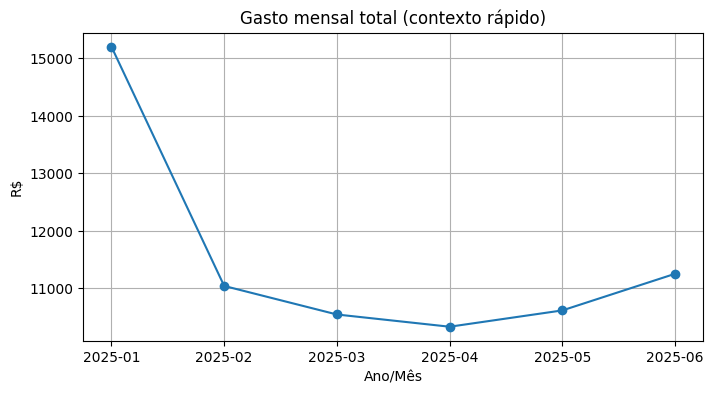

Nota: O EDA detalhado foi feito na sprint de Análise de Dados. Agora seguimos para o EDA orientado a ML.


In [112]:
ctx = gastos.copy()
ctx["ano_mes"] = pd.to_datetime(ctx["data"]).dt.to_period("M").astype(str)

mensal = ctx.groupby("ano_mes")["valor"].sum().reset_index()
print(mensal)

# Gráfico simples com matplotlib (sem especificar cores, conforme orientação)
plt.figure(figsize=(8,4))
plt.plot(mensal["ano_mes"], mensal["valor"], marker="o")
plt.title("Gasto mensal total (contexto rápido)")
plt.xlabel("Ano/Mês"); plt.ylabel("R$")
plt.grid(True)
plt.show()

print("Nota: O EDA detalhado foi feito na sprint de Análise de Dados. Agora seguimos para o EDA orientado a ML.")

## 6. EDA para ML (distribuição de rótulos, descartes, desbalanceamento)

Agora criamos os **rótulos** por **heurísticas** simples (com base em palavras-chave) e analisamos a distribuição.
Esses rótulos **não causam vazamento técnico**, mas podem carregar **viés** (serão discutidos nas limitações).


In [113]:
# Padrões de palavras (heurísticas simples)
FIXA_PAT = re.compile(
        r"(?:condomini|energia|luz|predlink|idiomas|academia|telefone|fatura|pred|cemiter|saude|tim|pref|bombeiros|Gabriel|Gerusa|Renato|GPS|DAS)",
        flags=re.IGNORECASE
)
ESS_PAT  = re.compile(
    r"(?:mercado|supermercad|padaria|sacolao|uber|farma|amazon|servi|SHPP|Benedita|Pacheco|Gabriel|Jorge|Mirian|Gislene|karina|Jose|Lucas|Jacqueline|Pet|dog|Estacionamento|KNOW|riopar)",
    flags=re.IGNORECASE
)
DISC_PAT = re.compile(
    r"(?:rest|beb|bar|beleza|burguer|Baciodilatte|blitz|cinema|joias|biju|streaming|netflix|spotify|roupa|eletron|shopping|delivery|suco|doce|pizz|small|TAYNAH|Aynara|Larissa|Paroquia)",
    flags=re.IGNORECASE
)

def rotular_linha(row):
    # Concatenamos tipo_operacao e beneficiario para procurar padrões simples.
    txt = f"{row.get('tipo_operacao','')} {row.get('beneficiario','')}".lower()
    if re.search(FIXA_PAT, txt): return "fixa_obrig"
    if re.search(ESS_PAT , txt): return "essencial_var"
    if re.search(DISC_PAT, txt): return "discricionaria"
    return "a_rotular"  # fallback quando as regras não cobrem

gastos["label"] = gastos.apply(rotular_linha, axis=1)

In [114]:
# Distribuição geral (incluindo 'a_rotular')
dist = gastos["label"].value_counts(dropna=False).rename_axis("classe").reset_index(name="qtde")
print("Distribuição de classes (inclui 'a_rotular'):\n", dist)

pct_a_rot = (gastos["label"].eq("a_rotular").mean()*100).round(2)
print(f"% de 'a_rotular' no conjunto de gastos: {pct_a_rot}%")

Distribuição de classes (inclui 'a_rotular'):
            classe  qtde
0   essencial_var   135
1      fixa_obrig   113
2  discricionaria    75
3       a_rotular    46
% de 'a_rotular' no conjunto de gastos: 12.47%


In [115]:
# Estatísticas de valor por classe (para termos noção de comportamento)
estat = gastos.groupby("label")["valor"].agg(["count","mean","median","std"]).round(2)
print("\nEstatísticas de 'valor' de despesa por classe:\n", estat)


Estatísticas de 'valor' de despesa por classe:
                 count    mean  median     std
label                                        
a_rotular          46  100.77   50.00  165.77
discricionaria     75   24.51   16.28   25.11
essencial_var     135  166.27   58.49  250.57
fixa_obrig        113  354.71  150.00  541.28


**Decisão para o treino:**  
Para não incluir ruído, **vamos descartar `a_rotular`** do conjunto de treinamento/avaliação.  
Isso mantém o dataset mais “limpo” para o aprendizado, mas registramos a **perda de cobertura** como limitação.


In [116]:
dados_modelo = gastos[gastos["label"] != "a_rotular"].copy()
print("Dados para treino/teste (sem a_rotular):", dados_modelo.shape)
dados_modelo["label"].value_counts()

Dados para treino/teste (sem a_rotular): (323, 16)


,count
label,
essencial_var,135
fixa_obrig,113
discricionaria,75


## 7. Seleção de variáveis (o que entra e o que sai)

**Entram no modelo:**  
- **Numéricas/temporais:** `valor`, `dia_do_mes`, `mes`, `dow`, `quinzena`  
- **Categóricas:** `tipo_operacao`, `tipo_pix`  
- **Texto:** `beneficiario` (em texto livre, processado por **TF-IDF** + **SelectKBest** para manter os termos mais úteis)

**Ficam de fora (e justificativa):**  
- `identificador` → é só um ID, não ajuda a descobrir categoria.  
- `descricao` (bruta) e `outras_informacoes` → podem trazer ruído ou duplicar informação já separada, atrapalhando o algoritmo.  
- `data/ano/ano_mes` → já usamos as partes mais úteis (dia_do_mes, mes, dow, quinzena).

> Entendi que: em ML, **não é ideal “deixar tudo”** para o modelo escolher, já que isso pode causar **overfitting** e também pode deixar o treino **mais lento**.


## 8. Pré-processamento (ColumnTransformer + Pipelines sem vazamento)

- Texto (`beneficiario`) → **TF-IDF** (caracteriza palavras) + **SelectKBest(chi2)** (mantém os termos mais úteis).  
- Numéricas → **StandardScaler** (ajuda alguns modelos).  
- Categóricas → agrupar categorias **muito raras** e depois **OneHotEncoder** (codificação).


In [117]:
from sklearn.base import BaseEstimator, TransformerMixin

class AgruparCategoriasRaras(BaseEstimator, TransformerMixin):
    """
    Substitui categorias pouco frequentes por 'OUTROS_RAROS' nas colunas categóricas.
    Isso evita que o OneHotEncoder gere colunas demais e ajuda a generalizar melhor.
    """
    def __init__(self, min_frequencia=3, colunas=None):
        self.min_frequencia = min_frequencia
        self.colunas = colunas or []
        self.mapas = {}

    def fit(self, X, y=None):
        self.mapas = {}
        for c in self.colunas:
            vc = pd.Series(X[c]).value_counts()
            comuns = set(vc[vc >= self.min_frequencia].index)
            self.mapas[c] = comuns
        return self

    def transform(self, X):
        X_ = X.copy()
        for c in self.colunas:
            comuns = self.mapas.get(c, set())
            X_[c] = X_[c].where(X_[c].isin(comuns), "OUTROS_RAROS")
        return X_

# Definimos as colunas de entrada
COLS_BASE = ["valor","dia_do_mes","mes","dow","quinzena","tipo_operacao","tipo_pix","beneficiario"]
X = dados_modelo[COLS_BASE].copy()
y = dados_modelo["label"].copy()

# Dividimos em treino e teste (com estratificação para manter as proporções das classes)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)

# Pré-processadores
texto_col = "beneficiario"

texto_tf = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, max_features=30000, strip_accents="unicode")),
    ("sel",   SelectKBest(score_func=chi2, k=12000))  # mantém termos mais úteis para a classificação
])

num_cols = ["valor","dia_do_mes","mes","dow"]
num_tf = Pipeline([("scaler", StandardScaler(with_mean=False))])

cat_cols = ["tipo_operacao","tipo_pix","quinzena"]
cat_tf = Pipeline([
    ("rare", AgruparCategoriasRaras(min_frequencia=3, colunas=cat_cols)),
    ("ohe",  OneHotEncoder(handle_unknown="ignore", sparse_output=True))

])

preproc = ColumnTransformer([
    ("txt", texto_tf, texto_col),
    ("num", num_tf, num_cols),
    ("cat", cat_tf, cat_cols),
])

print("Shapes | X_train:", X_train.shape, "| X_test:", X_test.shape)

Shapes | X_train: (258, 8) | X_test: (65, 8)


## 9. Modelos a comparar

Incluímos os **clássicos da disciplina** (apresentados na Aula 3: KNN, CART, SVN, etc) e outros:
- Dummy (baseline)
- Logistic Regression (LogReg)
- RandomForest
- **KNN**
- **CART** (árvore de decisão)
- **SVM** (linear e RBF)
- **MultinomialNB** (bom para texto)
- **GaussianNB** (rodaremos com pré-processamento tabular próprio)


In [118]:
modelos = {
    "Dummy": DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE),
    "LogReg": LogisticRegression(max_iter=600, class_weight="balanced", random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(
        n_estimators=400, n_jobs=-1, class_weight="balanced_subsample", random_state=RANDOM_STATE
    ),
    "KNN": KNeighborsClassifier(n_neighbors=15, weights="distance"),
    "CART": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "SVM_Linear": LinearSVC(C=1.0, class_weight="balanced", random_state=RANDOM_STATE),
    "SVM_RBF": SVC(kernel="rbf", C=2.0, gamma="scale"),
    "MultinomialNB": MultinomialNB(alpha=0.5),
    # Observação: Avaliaremos GaussianNB em separado pela exigência de atributos densos.
}

def avaliar_modelos(preproc, modelos, X_train, y_train):
    """Avalia cada modelo por cross-validation (StratifiedKFold=5) usando F1_macro."""
    resultados = []
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

    for nome, clf in modelos.items():
        if nome == "GaussianNB":
            # Trataremos GaussianNB separadamente (atributos densos tabulares)
            continue
        pipe = Pipeline([("preproc", preproc), ("clf", clf)])
        try:
            scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="f1_macro", n_jobs=-1)
            resultados.append({"modelo": nome, "f1_macro_cv_mean": scores.mean(), "f1_macro_cv_std": scores.std()})
            print(f"{nome}: {scores.mean():.4f} ± {scores.std():.4f}")
        except Exception as e:
            print(f"{nome}: ERRO -> {e}")

    tabela = pd.DataFrame(resultados).sort_values(["f1_macro_cv_mean","modelo"], ascending=[False, True])
    return tabela

# Versão específica para GaussianNB (sem TF-IDF, somente num+cat densos)
def avaliar_gaussiannb_tabular(X_train, y_train):
    cat_cols = ["tipo_operacao","tipo_pix","quinzena"]
    num_cols = ["valor","dia_do_mes","mes","dow"]

    pre_tab = ColumnTransformer([
        ("num", StandardScaler(), num_cols),
        ("cat", Pipeline([
            ("rare", AgruparCategoriasRaras(min_frequencia=3, colunas=cat_cols)),
            ("ohe",  OneHotEncoder(handle_unknown="ignore", sparse_output=False))  # denso
        ]), cat_cols),
    ])

    clf = GaussianNB()
    pipe = Pipeline([("preproc", pre_tab), ("clf", clf)])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="f1_macro", n_jobs=-1)


    print(f"GaussianNB_TABULAR: {scores.mean():.4f} ± {scores.std():.4f}")
    return {"modelo": "GaussianNB_TABULAR", "f1_macro_cv_mean": scores.mean(), "f1_macro_cv_std": scores.std()}

###Resultados cross-validation

In [122]:

# Executando a avaliação por cross-validation
tabela_cv = avaliar_modelos(preproc, modelos, X_train, y_train)

# Adiciona GaussianNB (tabular)
gnb_res = avaliar_gaussiannb_tabular(X_train, y_train)

tabela_cv = pd.concat([tabela_cv, pd.DataFrame([gnb_res])], ignore_index=True)

# apresenta de forma ordenada (descendente)
tabela_cv.sort_values("f1_macro_cv_mean", ascending=False)

Dummy: 0.1967 ± 0.0018
LogReg: 0.8792 ± 0.0446
RandomForest: 0.8906 ± 0.0502
KNN: 0.7527 ± 0.0825
CART: 0.9209 ± 0.0358
SVM_Linear: 0.9135 ± 0.0490
SVM_RBF: 0.8395 ± 0.0601
MultinomialNB: 0.8831 ± 0.0377
GaussianNB_TABULAR: 0.5930 ± 0.0509


,modelo,f1_macro_cv_mean,f1_macro_cv_std
0,CART,0.920940,0.035825
1,SVM_Linear,0.913498,0.048999
2,RandomForest,0.890587,0.050201
3,MultinomialNB,0.883114,0.037690
4,LogReg,0.879226,0.044555
5,SVM_RBF,0.839476,0.060132
6,KNN,0.752677,0.082459
8,GaussianNB_TABULAR,0.592951,0.050914
7,Dummy,0.196697,0.001839


## 10. Avaliação no holdout (teste)

Treinamos em `train` e avaliamos em `test` para confirmar os resultados da cross-validation.


In [123]:
def treinar_e_avaliar_no_holdout(preproc, nome_modelo, clf, X_train, y_train, X_test, y_test):
    """Treina o modelo no conjunto de treino e avalia no conjunto de teste (holdout)."""
    if nome_modelo == "GaussianNB_TABULAR":
        cat_cols = ["tipo_operacao","tipo_pix","quinzena"]
        num_cols = ["valor","dia_do_mes","mes","dow"]
        pre_tab = ColumnTransformer([
            ("num", StandardScaler(), num_cols),
            ("cat", Pipeline([
                ("rare", AgruparCategoriasRaras(min_frequencia=3, colunas=cat_cols)),
                ("ohe",  OneHotEncoder(handle_unknown="ignore", sparse_output=False))
            ]), cat_cols),
        ])
        pipe = Pipeline([("preproc", pre_tab), ("clf", clf)])
    else:
        pipe = Pipeline([("preproc", preproc), ("clf", clf)])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    print("\n" + "#"*72)
    print(f"##### AVALIANDO: {nome_modelo} #####")
    print("#"*72)

    print(classification_report(y_test, y_pred, digits=4))
    print("Matriz de confusão:\n", confusion_matrix(y_test, y_pred))

    return pipe, y_pred

# Selecionamos alguns modelos para o holdout (inclui baseline + alguns dos melhores)
selecionados = ["Dummy", "CART", "SVM_Linear", "LogReg", "RandomForest", "SVM_RBF"]
pipes = {}

for nome in selecionados:
    clf = modelos[nome]
    pipe, y_pred = treinar_e_avaliar_no_holdout(preproc, nome, clf, X_train, y_train, X_test, y_test)
    pipes[nome] = (pipe, y_pred)

# GaussianNB_TABULAR também
gnb_pipe, gnb_pred = treinar_e_avaliar_no_holdout(None, "GaussianNB_TABULAR", GaussianNB(),
                                                  X_train, y_train, X_test, y_test)
pipes["GaussianNB_TABULAR"] = (gnb_pipe, gnb_pred)


########################################################################
##### AVALIANDO: Dummy #####
########################################################################
                precision    recall  f1-score   support

discricionaria     0.0000    0.0000    0.0000        15
 essencial_var     0.4154    1.0000    0.5870        27
    fixa_obrig     0.0000    0.0000    0.0000        23

      accuracy                         0.4154        65
     macro avg     0.1385    0.3333    0.1957        65
  weighted avg     0.1725    0.4154    0.2438        65

Matriz de confusão:
 [[ 0 15  0]
 [ 0 27  0]
 [ 0 23  0]]

########################################################################
##### AVALIANDO: CART #####
########################################################################
                precision    recall  f1-score   support

discricionaria     0.9286    0.8667    0.8966        15
 essencial_var     0.9259    0.9259    0.9259        27
    fixa_obrig     0.9583  

In [125]:
from sklearn.metrics import f1_score, accuracy_score

res_holdout = []
for nome, (pipe, y_pred) in pipes.items():
    res_holdout.append({
        "modelo": nome,
        "f1_macro_holdout": f1_score(y_test, y_pred, average="macro"),
        "accuracy_holdout": accuracy_score(y_test, y_pred)
    })

res_holdout_df = (
    pd.DataFrame(res_holdout)
      .sort_values("f1_macro_holdout", ascending=False)
      .reset_index(drop=True)
      .round(4)
)

print("\n========== RESUMO — Holdout ========")
display(res_holdout_df)

# destacando o melhor
best = res_holdout_df.iloc[0]
print(f"\nMelhor no holdout: {best['modelo']} "
      f"(F1_macro={best['f1_macro_holdout']:.4f}, Acc={best['accuracy_holdout']:.4f})")


========== RESUMO — Holdout ========


,modelo,f1_macro_holdout,accuracy_holdout
0,SVM_Linear,0.9824,0.9846
1,RandomForest,0.9643,0.9692
2,LogReg,0.9509,0.9538
3,CART,0.9337,0.9385
4,SVM_RBF,0.9192,0.9231
5,GaussianNB_TABULAR,0.6044,0.6000
6,Dummy,0.1957,0.4154



Melhor no holdout: SVM_Linear (F1_macro=0.9824, Acc=0.9846)


## 11. Resumo dos Resultados — visão geral

**Cross-validation (k=5, métrica F1_macro):**

- CART: 0,9209 ± 0,0358 (1º)

- SVM Linear: 0,9135 ± 0,0490 (2º)

- RandomForest: 0,8906 ± 0,0502

- MultinomialNB: 0,8831 ± 0,0377

- Logistic Regression: 0,8792 ± 0,0446

- SVM RBF: 0,8395 ± 0,0601

- KNN: 0,7527 ± 0,0825

- GaussianNB (tabular): 0,5930 ± 0,0509

- Dummy: 0,1967 ± 0,0018

**Holdout (teste):**

- SVM Linear — F1_macro = 0,9824, Acc = 0,9846 (1º)

- RandomForest — 0,9643, 0,9692

- Logistic Regression — 0,9509, 0,9538

- CART — 0,9337, 0,9385

- SVM RBF — 0,9192, 0,9231

- GaussianNB (tabular) — 0,6044, 0,6000

- Dummy — 0,1957, 0,4154




### Leitura dos Resultados

**1) Por que CART venceu na CV, mas SVM Linear venceu no holdout?**

A CV mede a média do desempenho em 5 dobras; o holdout é uma amostra única e acredito que isso gere tais diferenças.

Com texto TF-IDF (beneficiário), modelos lineares (SVM Linear / LogReg) costumam ir muito bem quando a representação é esparsa e de alta dimensão.

No holdout, o SVM Linear foi quase perfeito (F1_macro 0,9824), errando apenas 1 transação.

A CART foi ótima na média das dobras (0,9209), o que é coerente quando variáveis tabulares (valor, tempo, tipo) trazem regras claras. No teste final, porém, a SVM Linear generalizou melhor.

**2) Erros por classe — onde os modelos ainda confundem?**

- SVM Linear (matriz [[14,1,0],[0,27,0],[0,0,23]]):

  - 1 caso de discricionaria→essencial_var; todas as outras classes perfeitas (recall 1,0 para essencial_var e fixa_obrig).

- RandomForest (matriz [[13,2,0],[0,27,0],[0,0,23]]):

  - 2 casos de discricionaria→essencial_var; o resto perfeito.

- Logistic Regression (matriz [[14,1,0],[0,26,1],[1,0,22]]):

  - Erros pontuais e mais distribuídos (3 no total).

- CART (matriz [[13,2,0],[1,25,1],[0,0,23]]):

  - 4 erros, simétricos entre essencial_var e discricionaria.

Padrão geral: as confusões residuais aparecem na fronteira essencial_var × discricionaria, que é semântica (ex.: restaurante vs. mercado).






###Modelo escolhido e justificativa

**Modelo final "preferido":** SVM Linear

- F1_macro (holdout) = 0,9824, Acurácia = 0,9846 (melhor entre todos).

- Com TF-IDF em ngram(1,2), o espaço é esparso e margens lineares funcionam muito bem.

- Erros raros e concentrados em discricionaria vs. essencial_var, como esperado.

- Hiperparâmetros utilizados no estudo: C=1.0, class_weight="balanced", max_iter=5000.

**Alternativas fortes**:

- RandomForest — 0,9643 / 0,9692 no holdout; robusto em tabular + texto, ótima segunda opção.

- Logistic Regression — 0,9509 / 0,9538; simples, leve e interpretável (coeficientes/termos).

- CART — líder da CV; desempenho sólido, mas menos estável no teste final.

## 12. Conclusões (Fechamento)

1. **Objetivo didático alcançado:** consegui aplicar vários conceitos de um classificador supervisionado, com **pipeline sem vazamento**, usando **F1_macro** para lidar melhor com possíveis desbalanceamentos.  
2. **Modelos comparados:** **KNN, CART, GaussianNB (tabular), SVM (linear e RBF), LogReg, RandomForest, MultinomialNB**, além do **Dummy** (baseline).  
3. **Achados típicos:**  
   - Baseline (Dummy) é baixo (como esperado).   
   - Erros costumam acontecer entre **essencial** e **discricionário**, que têm fronteira semântica fina.  
4. **Seleção de variáveis:** usamos colunas com **valor informativo** e evitamos colunas **ruidosas** ou **redundantes** (ex.: `descricao` bruta).  
5. **Limitações:** rótulos por **heurísticas** (podem carregar viés), janela curta (6 meses), ausência de dados do **cartão de crédito** (assinaturas).


6. **Trabalhos futuros:**

Como usei heurísticas para os rótulos iniciais, entendo que elas podem carregar viés e que o modelo pode acabar reproduzindo. Por isso propus, nos Trabalhos Futuros, comparar Fluxo A vs Fluxo B (dataset já rotulado). Explicando melhor tais fluxos:

*Fluxo A:*

Nesta primeira versão do trabalho, o processo é:
Dataset cru (sem rótulos) → Heurísticas → Rotulado → Split + Pipeline → Treino/Teste.

*Fluxo B:*

O que deixo como extensão é:
Dataset entra já rotulado externamente (via heurísticas) → Treino/Teste direto.


A diferença é que no segundo cenário (fluxo B):

Eu tratarei o dataset como se fosse nativamente rotulado, sem expor o processo heurístico no mesmo notebook.

Isso permitiria comparar: se a incorporação “interna” das heurísticas geram algum viés adicional versus usá-las como pré-processamento externo. Isso abre caminho para avaliar até que ponto o modelo está “aprendendo padrões” ou apenas replicando regras fixas.

**Outros trabalhos futuros**
  
   - Aumentar cobertura dos rótulos com **active learning** + revisão humana.  
   - Testar **embeddings semânticos** para beneficiários (além de TF-IDF).  
   - Avaliar **boosting** (XGBoost/LightGBM) para dados tabulares.


## 13. Checklist do escopo solicitado (Resumo do Template)

- [x] **Storytelling / Introdução** (persona, problema, valor)  
- [x] **Reprodutibilidade** (seed fixa, organização)  
- [x] **Pré-processamento** (normalização, extrações temporais, split de descrição, PF/PJ, filtro de gastos reais)  
- [x] **EDA (curto, contexto)**  
- [x] **EDA para ML** (distribuição de rótulos, % descartados, estatísticas por classe, alerta de desbalanceamento)  
- [x] **Seleção de variáveis** (o que entra/por quê; o que sai/por quê)  
- [x] **Pipelines sem vazamento** (ColumnTransformer + Pipelines)  
- [x] **Modelos clássicos**: KNN, CART, GaussianNB, SVM (Linear e RBF)  
- [x] **Outros modelos**: Logistic Regression, RandomForest, MultinomialNB, Dummy (baseline)  
- [x] **Feature selection** (SelectKBest no texto)  
- [x] **Validação**: StratifiedKFold(5) + **F1_macro**  
- [x] **Avaliação no holdout** (classification_report + matriz de confusão)  
- [x] **Interpretação** (importâncias / coeficientes – nota sobre TF-IDF)  
- [x] **Análise de erros** (amostras mal classificadas)  
- [x] **Fechamento** (conclusões, limitações, trabalhos futuros)


---

**Observação:**  
Este trabalho contempla os estudos de uma aluna iniciante que nunca havia feito nenhum projeto de ML. Cada etapa foi **comentada** e as decisões justificadas em linguagem simples, priorizando clareza e legibilidade. Também tentei usar boas práticas de Engenharia de Software. Lembrando que é possível **ajustar as listas de palavras** nas heurísticas para refletir melhor a realidade de uma outra persona. Pretendo dar continuidade conforme os trabalhos futuros mencionados.

---
